In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# グラフを描画するライブラリ
from matplotlib import pylab as plt
import seaborn as sns

sns.set()

# グラフの日本語表記
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 80)

from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = 8, 4

In [3]:
# 乱数の種を固定（再現性を確保）
np.random.seed(1)

# シミュレーションするデータの長さを指定
sim_size = 100

# 正規分布に従う乱数を生成し、その累積和を取る
# → 各時点の値が「前の時点の値＋ランダム誤差」で決まるランダムウォーク過程を作成
mu_cumsum = np.cumsum(stats.norm.rvs(loc=0, scale=1, size=sim_size))

# 結果として mu_cumsum は、次の式で表される：
# μ_t = μ_{t-1} + ε_t,   ε_t ~ N(0, 1)

In [4]:
# 乱数の種を固定（再現性の確保）
np.random.seed(1)

# シミュレーションするデータ数
sim_size = 100

# ランダムウォーク系列を格納する配列を初期化
mu_for = np.zeros(sim_size)

# 初期値（t = 0）を標準正規分布から生成
mu_for[0] = stats.norm.rvs(loc=0, scale=1, size=1)[0]

# 各時点 t における値を再帰的に生成
# y_t = y_{t-1} + ε_t  （ε_t ~ N(0, 1)）
for t in range(1, sim_size):
    mu_for[t] = mu_for[t - 1] + stats.norm.rvs(loc=0, scale=1, size=1)[0]

In [5]:
# 結果の比較：2通りの生成方法で同一のランダムウォークを作成できたか確認
all(mu_cumsum == mu_for)

True

In [6]:
# --------------------------------------------
# 乱数の種設定（再現性の確保）
# --------------------------------------------
np.random.seed(1)

# --------------------------------------------
# シミュレーション設定
# --------------------------------------------
# 観測数（サンプルサイズ）
sim_size = 100

# --------------------------------------------
# ドリフト成分（Δ_t）の初期化
# --------------------------------------------
# Δ_t ~ N(0, 1) と仮定するランダムウォーク的ドリフト
# 初期値 Δ_0 = 0 とし、1期目のみ乱数を代入
delta = np.zeros(sim_size)
delta[1] = stats.norm.rvs(loc=0, scale=1, size=1)[0]

# --------------------------------------------
# 水準成分（μ_t）の初期化
# --------------------------------------------
# μ_t = μ_{t-1} + Δ_t + ε_t の形を後で構築するため、
# ここでは μ_t の格納配列をゼロで初期化
mu_smooth = np.zeros(sim_size)

In [7]:
# --------------------------------------------
# ローカル線形トレンドモデルのシミュレーション
# --------------------------------------------
# モデル構造：
#   y_t = μ_t + ε_t
#   μ_t = μ_{t-1} + δ_{t-1}
#   δ_t = δ_{t-1} + η_t
#   ε_t ~ N(0, σ_ε²), η_t ~ N(0, σ_η²)
# --------------------------------------------

for t in range(2, sim_size):
    # ドリフト（傾き）成分の更新： δ_t = δ_{t-1} + η_t
    delta[t] = delta[t - 1] + stats.norm.rvs(loc=0, scale=1, size=1)[0]

    # 水準（レベル）成分の更新： μ_t = μ_{t-1} + δ_{t-1}
    mu_smooth[t] = mu_smooth[t - 1] + delta[t - 1]

# --------------------------------------------
# 観測値の生成： y_t = μ_t + ε_t
# --------------------------------------------
# 観測ノイズの分散 σ_ε² = 15² として、観測系列 y_t を生成
y_smooth = mu_smooth + stats.norm.rvs(loc=0, scale=15, size=sim_size)

In [8]:
# --------------------------------------------
# シミュレーション結果を DataFrame にまとめる
# --------------------------------------------
#   - delta: トレンドの傾き（slope） δ_t
#   - mu:    水準（level） μ_t
#   - y:     観測値（observation） y_t = μ_t + ε_t
#   - index: 日付（月次データとして2000年1月から）
# --------------------------------------------

smooth_df = pd.DataFrame(
    {"delta": delta, "mu": mu_smooth, "y": y_smooth},
    index=pd.date_range(start="2000-01-01", periods=sim_size, freq="MS"),
)

# 結果の確認（先頭3行）
print(smooth_df.head(3))

               delta        mu          y
2000-01-01  0.000000  0.000000  10.470481
2000-02-01  1.624345  0.000000  -6.706928
2000-03-01  1.012589  1.624345  19.991961


<Axes: >

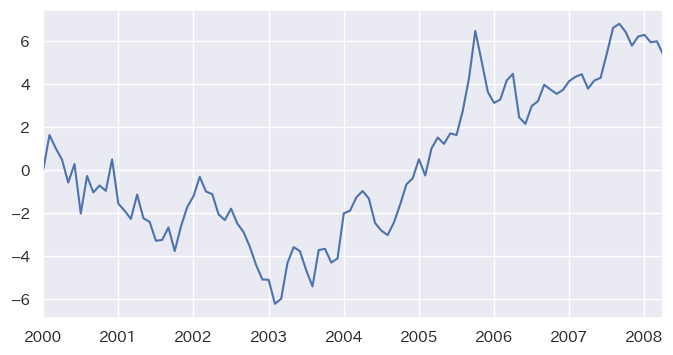

In [9]:
# --------------------------------------------
# ドリフト成分（傾き δ_t）の可視化
# --------------------------------------------
# ここでは、局所線形トレンドモデルにおける
# 「傾き（トレンドの変化率）」を表す δ_t をプロットしている。
# δ_t は状態方程式：
#   δ_t = δ_{t-1} + η_t,    η_t ~ N(0, σ_η²)
# に従うため、ゆるやかに変動するトレンドの滑らかさを可視化できる。
# --------------------------------------------

smooth_df["delta"].plot()

<Axes: >

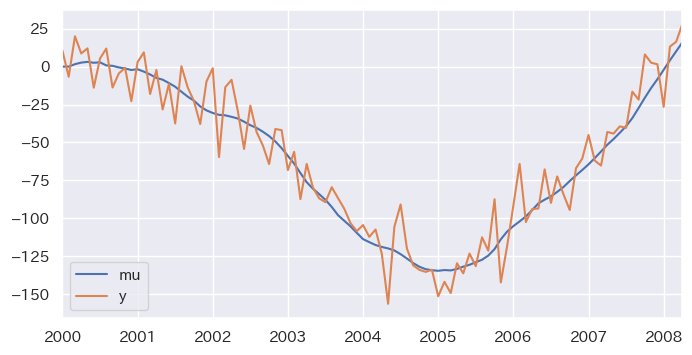

In [10]:
# --------------------------------------------
# 水準成分（μ_t）と観測値（y_t）の可視化
# --------------------------------------------
# μ_t は系列の「基調的な水準（trend level）」を表す潜在変数。
# 局所線形トレンドモデルにおける状態方程式：
#     μ_t = μ_{t-1} + δ_{t-1}
# により、ゆるやかに変化するトレンドを形成する。
#
# 一方、y_t は観測値であり、観測方程式：
#     y_t = μ_t + ε_t,   ε_t ~ N(0, σ_ε²)
# に従って、μ_t の周りにノイズとして分布する。
#
# このグラフでは、観測値 y_t（青線）と真の水準成分 μ_t（オレンジ線）
# を重ねて描画することで、観測ノイズによる揺らぎと
# 真のトレンドの滑らかさを対比的に確認できる。
# --------------------------------------------

smooth_df[["mu", "y"]].plot()

In [11]:
# --------------------------------------------------------
# 水準成分 μ_t は「正規ホワイトノイズの2階累積和」として表せる
# --------------------------------------------------------
# 局所線形トレンドモデル（Local Linear Trend Model）では：
#
#     μ_t = μ_{t-1} + δ_{t-1}
#     δ_t = δ_{t-1} + η_t,   η_t ~ N(0, σ_η²)
#
# したがって、δ_t はホワイトノイズ η_t の累積和、
# μ_t はそのさらに累積和、すなわち「2階累積和」となる。
#
# 言い換えれば、μ_t は「2階の積分過程」に相当し、
# 差分を2回とると定常系列になる（＝2階差分過程）。
#
# このことが、「局所線形トレンドモデルは 2階差分に由来する」
# といわれる理由である。
# --------------------------------------------------------

np.random.seed(1)
cumsum2 = np.cumsum(np.cumsum(stats.norm.rvs(loc=0, scale=1, size=sim_size)))

all(cumsum2[0:98] == mu_smooth[2:])

True

In [12]:
# ============================================================
# 📘 平滑化トレンドモデル（Local Linear Trend Model）
# ============================================================
# モデル仕様：
#   level='smooth trend' とすることで、以下の状態空間モデルを指定する。
#
#   観測方程式：
#       y_t = μ_t + ε_t,      ε_t ~ N(0, σ_ε²)
#
#   状態方程式（2階差分構造）：
#       μ_t = μ_{t-1} + δ_{t-1}
#       δ_t = δ_{t-1} + η_t,  η_t ~ N(0, σ_η²)
#
#   → μ_t は正規ホワイトノイズの2階累積和に相当（ARIMA(0,2,0) と等価）
#
# ============================================================
# 推定方法：
#   - statsmodels.tsa.UnobservedComponents を用いる。
#   - level='smooth trend' は「局所線形トレンドモデル」を意味する。
#   - method='nm' は Nelder-Mead 法による最尤推定を行う。
#   - maxiter=2000 は収束計算の繰り返し上限回数を指定。
# ============================================================

mod_smooth = tsa.UnobservedComponents(
    smooth_df["y"],  # 観測データ（シミュレーションされた系列）
    level="smooth trend",  # モデルの種類（平滑化トレンド）
)

# 最尤法によるパラメータの推定
res_smooth = mod_smooth.fit(
    method="nm", maxiter=2000  # Nelder-Mead法を使う  # 最大繰り返し数
)

Optimization terminated successfully.
         Current function value: 4.165624
         Iterations: 52
         Function evaluations: 103


In [13]:
# ============================================================
# 📘 推定された分散パラメータの平方根（標準偏差）
# ============================================================
# res_smooth.params には最尤推定された分散パラメータ（σ²）が格納されている。
#   1. σ_ε² : 観測誤差（Irregular）の分散
#   2. σ_η² : 過程誤差（Trend）の分散
#
# これらを平方根に変換することで、実際の標準偏差（σ）を求める：
#   √σ² = σ
#
# 例：
#   [σ_ε, σ_η] = np.sqrt(res_smooth.params)
#
# → モデル内部の不確実性（ノイズの大きさ）を直感的に理解できる。
# ============================================================

np.sqrt(res_smooth.params)

sigma2.irregular    14.138599
sigma2.trend         0.719196
dtype: float64

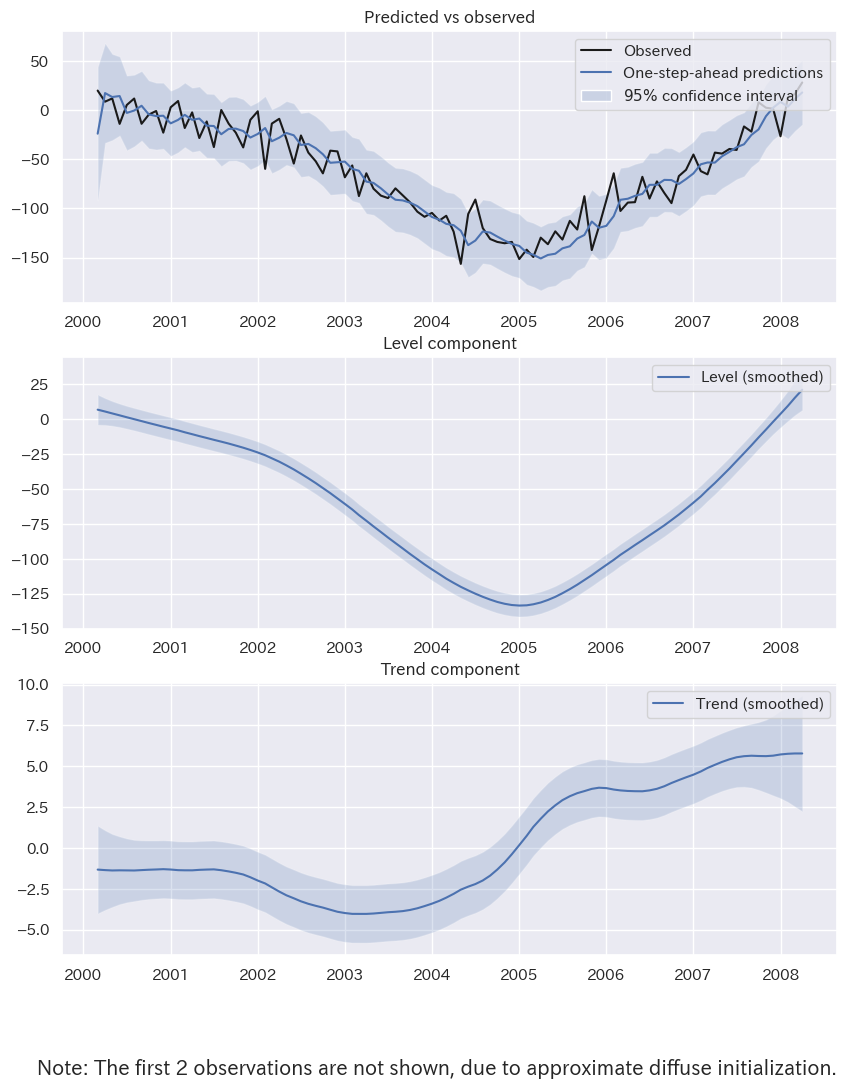

In [14]:
# ============================================================
# 📘 状態空間モデルの可視化：平滑化トレンドモデル
# ============================================================
# res_smooth.plot_components() は、推定された各成分（状態・トレンドなど）を可視化する。
#
# 【出力される主なプロット】
# 1️⃣ 観測系列 (Observed)：
#     実際の観測値 y_t（ノイズを含む系列）
#
# 2️⃣ Level（状態成分 α_t）：
#     トレンドの「水準」を表す。滑らかな時系列変化を捉える。
#
# 3️⃣ Trend（トレンド成分 Δα_t）：
#     水準の変化速度（勾配）を示す。増加・減少の傾向を反映。
#
# 【ポイント】
# - 「平滑化トレンドモデル (Smooth Trend Model)」は次のような構造：
#       y_t = μ_t + ε_t,       ε_t ~ N(0, σ_ε²)
#       μ_t = μ_{t-1} + δ_{t-1} + η_t,  η_t ~ N(0, σ_η²)
#       δ_t = δ_{t-1} + ζ_t,           ζ_t ~ N(0, σ_ζ²)
#
# - つまり、状態 μ_t（トレンド水準）と δ_t（トレンド勾配）が
#   ともにランダムウォークする「ランダムトレンドモデル」に近い。
#
# - プロットでは、推定された μ_t（レベル）と δ_t（トレンド）の
#   時間変化を視覚的に確認できる。
# ============================================================

fig = res_smooth.plot_components(figsize=(10, 12))

Text(0, 0.5, 'ドリフト（傾き）')

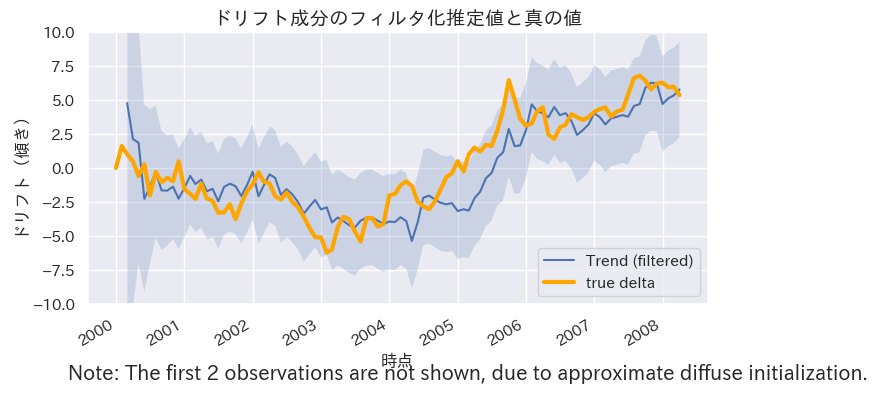

In [15]:
# ============================================================
# 🎯 ドリフト成分（傾き）のフィルタ化推定値の可視化
# ============================================================
# res_smooth.plot_components() を用いて、状態空間モデルから
# 推定された「ドリフト（trend）成分」のフィルタ化推定値を描画。
# さらに、シミュレーションで生成した真のドリフト値を重ねることで、
# モデルの推定性能を視覚的に検証する。
# ------------------------------------------------------------
# 【理論的背景】
# 平滑化トレンドモデル（Smooth Trend Model）は次のように表される：
#
# $$
# \begin{aligned}
# y_t &= \mu_t + \varepsilon_t, \quad \varepsilon_t \sim N(0, \sigma_\varepsilon^2) \\
# \mu_t &= \mu_{t-1} + \delta_{t-1} + \eta_t, \quad \eta_t \sim N(0, \sigma_\eta^2) \\
# \delta_t &= \delta_{t-1} + \zeta_t, \quad \zeta_t \sim N(0, \sigma_\zeta^2)
# \end{aligned}
# $$
#
# - $\mu_t$: トレンドの水準（Level）
# - $\delta_t$: トレンドの傾き（Drift）
# - $\varepsilon_t, \eta_t, \zeta_t$: 各ノイズ項
#
# フィルタ化推定値（Filtered Estimate）は、時点 $t$ までの情報を用いて
# 推定した $\delta_t$ の期待値である。
# ============================================================

fig = res_smooth.plot_components(
    which="filtered",  # フィルタ化推定値を描画
    observed=False,  # 観測値は非表示
    level=False,  # 水準成分は非表示
    trend=True,  # ドリフト成分のみ表示
    seasonal=False,  # 季節成分は非表示
    figsize=(8, 4),  # 図のサイズ
)

# ------------------------------------------------------------
# ✅ 真のドリフト成分（シミュレーションで生成した delta）を重ね描画
# ------------------------------------------------------------
smooth_df.delta.plot(linewidth=3, label="true delta", color="orange")

# 凡例
plt.legend()

# Y軸範囲の調整（-10〜10）
plt.ylim(-10, 10)
plt.title("ドリフト成分のフィルタ化推定値と真の値", fontsize=14)
plt.xlabel("時点", fontsize=12)
plt.ylabel("ドリフト（傾き）", fontsize=12)

In [16]:
# ============================================================
# 🎯 ドリフト成分（trend）のフィルタ化・平滑化推定値の取得
# ============================================================
# 状態空間モデル（平滑化トレンドモデル）から、
# トレンドの傾き（ドリフト成分）に関する推定値を取り出す。
#
# res_smooth.trend['filtered'] : カルマンフィルタによる逐次推定結果
# res_smooth.trend['smoothed'] : カルマンスムーザによる事後推定結果
# ------------------------------------------------------------
# 【理論的背景】
# フィルタ化推定値：
#   $$ E[\delta_t | y_1, ..., y_t] $$
#   ┗ 時点 t までの情報を使って算出（リアルタイム予測）
#
# 平滑化推定値：
#   $$ E[\delta_t | y_1, ..., y_T] $$
#   ┗ サンプル全体（T時点までの観測）を使って後から修正した推定値
#
# 一般に、平滑化推定値の方が真値に近いとされる。
# ============================================================

# フィルタ化推定量（時点 t までの情報でのドリフト推定）
print("📘 フィルタ化推定量（Filtered Estimate）:")
print(res_smooth.trend["filtered"][:4])

# 平滑化推定量（全時点の情報を使って後から補正された推定値）
print("\n📗 平滑化推定量（Smoothed Estimate）:")
print(res_smooth.trend["smoothed"][:4])

📘 フィルタ化推定量（Filtered Estimate）:
[  0.         -17.16845309   4.77003853   2.13530599]

📗 平滑化推定量（Smoothed Estimate）:
[-1.29717419 -1.29385304 -1.32497374 -1.35586851]


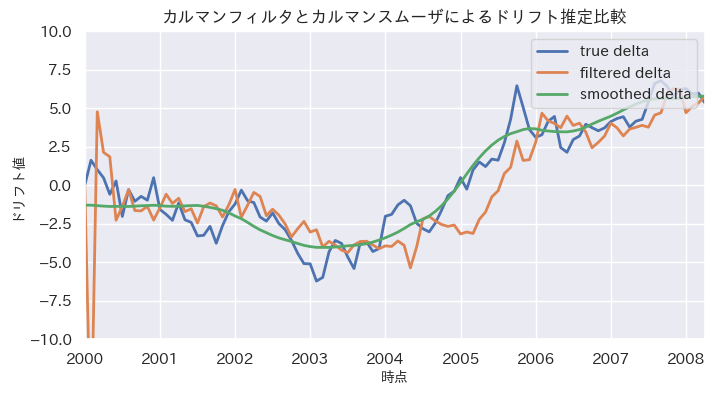

In [17]:
# ============================================================
# 🎯 ドリフト成分（trend）の真値・フィルタ化・平滑化の比較可視化
# ============================================================
# カルマンフィルタとカルマンスムーザによる推定精度を比較。
#   - True delta：シミュレーションで生成した真のドリフト成分
#   - Filtered delta：観測時点までの情報で推定した逐次推定値
#   - Smoothed delta：全時点の情報を用いて補正した事後推定値
# ------------------------------------------------------------
# 期待される結果：
#   ・平滑化推定値（smoothed）は真値（true delta）に最も近くなる
#   ・フィルタ化推定値（filtered）は滑らかだが若干遅れる
# ============================================================

# DataFrameにまとめる
plot_df = pd.DataFrame(
    {
        "true delta": smooth_df.delta,
        "filtered delta": res_smooth.trend["filtered"],
        "smoothed delta": res_smooth.trend["smoothed"],
    }
)

# 可視化
plot_df.plot(figsize=(8, 4), linewidth=2)
plt.title("カルマンフィルタとカルマンスムーザによるドリフト推定比較", fontsize=12)
plt.xlabel("時点", fontsize=10)
plt.ylabel("ドリフト値", fontsize=10)
plt.ylim(-10, 10)
plt.legend(loc="upper right")

# ✅ GitHubレビューコメント
# この図は、状態空間モデルのトレンド成分（ドリフト）の推定過程を可視化している。
# 平滑化推定（Smoothed）は過去・未来の情報を用いるため真値により近く、
# フィルタ化推定（Filtered）は観測時点までの情報で更新されるため若干遅れる。
# これにより、カルマンフィルタとカルマンスムーザの役割の違いが直感的に理解できる。

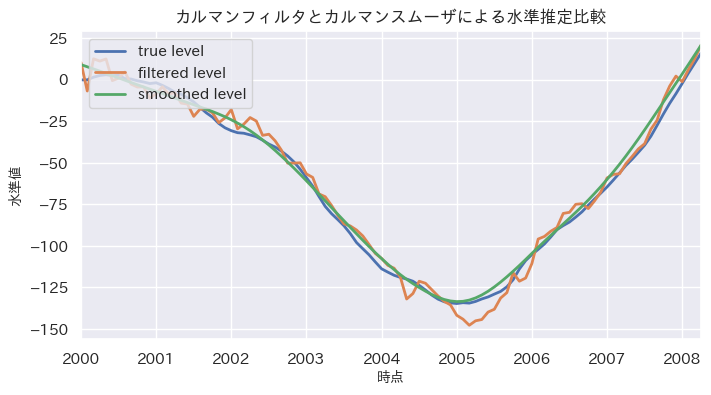

In [18]:
# ============================================================
# 🎯 水準成分（level）の真値・フィルタ化・平滑化の比較可視化
# ============================================================
# カルマンフィルタとカルマンスムーザによる「水準」の推定精度を比較。
#   - True level：シミュレーションで生成した真の水準成分
#   - Filtered level：観測時点までの情報で更新された逐次推定値
#   - Smoothed level：全時点の情報を用いて補正された事後推定値
# ------------------------------------------------------------
# 期待される結果：
#   ・平滑化推定値（smoothed）は真値（true level）に最も近くなる
#   ・フィルタ化推定値（filtered）は若干遅れが見られる
# ============================================================

# DataFrameにまとめる
plot_df = pd.DataFrame(
    {
        "true level": smooth_df.mu,
        "filtered level": res_smooth.level["filtered"],
        "smoothed level": res_smooth.level["smoothed"],
    }
)

# 可視化
plot_df.plot(figsize=(8, 4), linewidth=2)
plt.title("カルマンフィルタとカルマンスムーザによる水準推定比較", fontsize=12)
plt.xlabel("時点", fontsize=10)
plt.ylabel("水準値", fontsize=10)
plt.legend(loc="upper left")

# ✅ GitHubレビューコメント
# この図は、状態空間モデルにおける水準（level）推定の精度を比較している。
# フィルタ化推定（Filtered）は逐次更新によるリアルタイム推定、
# 平滑化推定（Smoothed）は全情報を使った最終的な補正推定であり、
# 後者が真値に最も近づくことが確認できる。

In [19]:
# ============================================================
# 🎯 ランダムウォークドリフト成分（Local Linear Trend Model の前段準備）
# ============================================================
# 状態空間モデルの「ローカル線形トレンドモデル（local linear trend）」の基礎を作る。
#   - ドリフト成分（delta_t）: トレンドの変化率。ランダムウォーク過程に従う。
#   - 水準成分（mu_t）: 系列の平均的水準。ドリフト成分を累積して決まる。
# ------------------------------------------------------------
# 数式表現：
#   δ_t = δ_{t-1} + η_t,     η_t ~ N(0, σ_η²)
#   μ_t = μ_{t-1} + δ_{t-1}
# ============================================================

# 乱数の種を固定（再現性の確保）
np.random.seed(1)

# シミュレーションする時系列の長さ
sim_size = 100

# ------------------------------------------------------------
# ドリフト成分 δ_t（トレンドの傾きの変動）
# ------------------------------------------------------------
# 初期値はゼロに設定
delta = np.zeros(sim_size)

# 1期目のドリフト成分のみランダムに与える（平均0, 分散1 の正規分布）
delta[1] = stats.norm.rvs(loc=0, scale=1, size=1)[0]

# ------------------------------------------------------------
# 水準成分 μ_t（系列の平均的水準）
# ------------------------------------------------------------
# 初期値はゼロ（系列が0から始まると仮定）
mu_trend = np.zeros(sim_size)

# ✅ GitHubレビューコメント
# このセルでは、トレンドを構成する「傾き（delta_t）」と「水準（mu_t）」の
# 基本的な状態ベクトルを初期化している。
# 次のステップで、これらを再帰的に更新し、ローカル線形トレンド系列を生成する。

In [20]:
# ============================================================
# 🎯 ローカル線形トレンドモデル（Local Linear Trend Model）のシミュレーション
# ============================================================
# 状態方程式：
#   δ_t = δ_{t-1} + η_t,  η_t ~ N(0, σ_η²)
#   μ_t = μ_{t-1} + δ_t + ζ_t, ζ_t ~ N(0, σ_ζ²)
# 観測方程式：
#   y_t = μ_t + ε_t,  ε_t ~ N(0, σ_ε²)
# ------------------------------------------------------------
# ここでは：
#   ・η_t（トレンドの変動）に対応する分散 = 1
#   ・ζ_t（平滑化ノイズ）に対応する分散 = 10²
#   ・ε_t（観測ノイズ）に対応する分散 = 15²
# として、100期間のデータを生成する。
# ============================================================

# シミュレーション実行
for t in range(2, sim_size):
    # ドリフト成分 δ_t の更新（ランダムウォーク）
    delta[t] = delta[t - 1] + stats.norm.rvs(loc=0, scale=1, size=1)[0]

    # 水準成分 μ_t の更新（前期の水準 + 現在のトレンド + 平滑化ノイズ）
    mu_trend[t] = (
        mu_trend[t - 1]
        + delta[t]  # 現在の傾き（トレンド）を反映
        + stats.norm.rvs(loc=0, scale=10, size=1)[0]  # 平滑化ノイズ ζ_t
    )

# 観測方程式：観測値 y_t = μ_t + ε_t
y_trend = mu_trend + stats.norm.rvs(loc=0, scale=15, size=sim_size)

# ✅ GitHubレビューコメント
# - ドリフト成分（delta）はトレンドの傾きを示し、滑らかに変化する。
# - 水準成分（mu_trend）はその累積であり、全体的なトレンドを形成する。
# - 最後に観測ノイズ（ε_t）を加えることで観測データ y_t が得られる。
# これにより、現実的な非定常系列（トレンド＋ノイズ）を再現できる。

In [21]:
# ============================================================
# 📊 データの統合と確認
# ============================================================
# 生成したドリフト成分(delta)、水準成分(mu_trend)、観測値(y_trend)
# をひとまとめにして、時系列DataFrameとして格納する。
# インデックスには2000年1月から月次(MS)で100期間の連続した日付を設定する。
# ============================================================

trend_df = pd.DataFrame(
    {
        "delta": delta,  # ドリフト成分：トレンドの傾き
        "mu": mu_trend,  # 水準成分：系列の基準水準
        "y": y_trend,  # 観測値：水準＋ノイズ
    },
    index=pd.date_range(start="2000-01-01", periods=sim_size, freq="MS"),
)

# ============================================================
# 結果の確認
# 先頭3行を出力して、生成された系列の構造を確認する。
# ============================================================

print(trend_df.head(3))

               delta        mu          y
2000-01-01  0.000000  0.000000   6.304233
2000-02-01  1.624345  0.000000  12.164275
2000-03-01  1.012589 -4.269129  11.397503


<Axes: title={'center': '水準成分と観測値の比較'}, xlabel='年月', ylabel='値'>

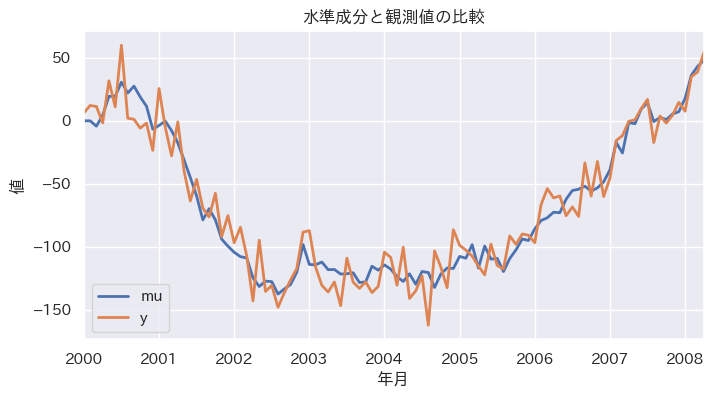

In [22]:
# ============================================================
# 📈 水準成分と観測値の可視化
# ============================================================
# 「mu」：真の水準成分（トレンド）
# 「y」 ：観測値（ノイズを含む実際の観測系列）
# ============================================================
# これにより、観測値がトレンド周りにどの程度ばらついているか、
# モデルがどのようなノイズ構造を前提としているかを視覚的に確認できる。
# ============================================================

trend_df[["mu", "y"]].plot(
    figsize=(8, 4),
    title="水準成分と観測値の比較",
    xlabel="年月",
    ylabel="値",
    linewidth=2,
)

# 💡 GitHubレビュー用コメント：
# グラフは「観測値 y_t」が真のトレンド μ_t の周囲を振動する様子を示す。
# この構造は、後に適用する「平滑化トレンドモデル（Local Linear Trend Model）」の前提に一致し、
# トレンド変化を含む非定常系列におけるモデル化の直感的理解を助ける。